## **Assignment 2**  
**02805 Social Graphs & Interactions**  

**Group 13** 
- Anna Bøgevang Ekner (s193396)
- Morten Møller Christensen (s204258)


In [666]:
import re
import os
import json
import nltk
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from fa2_modified import ForceAtlas2

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
sns.set(font_scale=1.)

# **Part 1: Genres and communities and plotting**

### **Loading and pre-processing the undirected graph**

In [494]:
def load_data():
    """
    Load the artist genre data and the undirected country musician graph

    Returns
        artist_genres_dict: dictionary of artist genres (dict)
        country_performer_undir_graph: undirected graph of country musicians (nx.Graph)
    """
    # Load the artist genre data
    artist_genres = open('artists_genres_dictionary.txt', 'r')
    raw_data = artist_genres.read() 

    # Convert into dictionary
    artist_genres_dict = eval(raw_data)

    # Load the undirected graph from the json file
    with open('undirected_graph.txt', 'r', encoding='utf-8') as f:
        undirected_graph_json = json.load(f)

    undirected_graph_data = json.loads(undirected_graph_json)
    country_performer_undir_graph = nx.node_link_graph(undirected_graph_data)

    return artist_genres_dict, country_performer_undir_graph

artist_genres_dict, country_performer_undir_graph = load_data()


Delete the cell below:

In [495]:
# Check the counts of each genre (value) in the artist_genres_dict
genres = list(artist_genres_dict.values())
genres_flat = [x for xs in genres for x in xs]
values, counts = np.unique(genres_flat, return_counts=True)
not_one = (counts != 1).sum()
# print(not_one)
# print(values)

# Dictionary of genre and their counts
genre_counts = dict(zip(values, counts))

# sort after highest values
genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))
print(genre_counts)

{'country': 1499, 'folk': 178, 'country rock': 171, 'americana': 157, 'pop': 157, 'bluegrass': 129, 'rock': 116, 'country pop': 109, 'gospel': 96, 'rockabilly': 80, 'blues': 79, 'alternative country': 73, 'folk rock': 60, 'southern rock': 51, 'rock and roll': 50, 'outlaw country': 40, 'country music': 36, 'pop rock': 35, 'jazz': 34, 'soft rock': 34, 'progressive country': 31, 'roots rock': 29, 'neotraditional country': 27, 'western swing': 27, 'blues rock': 24, 'honky-tonk': 23, 'soul': 23, 'alternative rock': 20, 'texas country': 20, 'western': 20, 'hard rock': 19, 'progressive bluegrass': 17, 'country folk': 15, 'red dirt': 15, 'traditional pop': 15, 'nashville sound': 14, 'old-time': 14, 'country rap': 12, 'honky tonk': 12, 'indie rock': 12, 'bakersfield sound': 11, 'christian': 11, 'hip hop': 11, 'ccm': 10, 'indie folk': 10, 'heartland rock': 9, 'old-time music': 9, 'adult contemporary': 8, 'alt-country': 8, 'ameripolitan': 8, 'countrypolitan': 8, 'jam band': 8, 'southern gospel': 

In [496]:
def preprocess_graph(artist_genres_dict, country_performer_undir_graph):
    """ 
    Preprocess the graph by keeping only the nodes that have genre information, 
    and also remove the article_length attribute from all nodes.

    Args
        artist_genres_dict: dictionary of artist genres (dict)
        country_performer_undir_graph: undirected graph of country musicians (nx.Graph)

    Returns
        artist_undirected_graph: preprocessed undirected graph of country musicians (nx.Graph)
    """
    # Keep only the nodes that have genre information
    artist_undirected_graph = country_performer_undir_graph.copy()

    for node in list(country_performer_undir_graph.nodes()):

        # Remove the article_length attribute
        if 'article_length' in artist_undirected_graph.nodes[node]:
            del artist_undirected_graph.nodes[node]['article_length']

        if node.replace('_', ' ') not in artist_genres_dict:
            artist_undirected_graph.remove_node(node)

    return artist_undirected_graph

artist_undirected_graph_preprocessed = preprocess_graph(artist_genres_dict, country_performer_undir_graph)

print(f'Artist genre dictionary')
print(f'\tNumber of artists: {len(artist_genres_dict)}\n')

print(f'Artist graph (undirected)')
print(f'\tNumber of nodes: {artist_undirected_graph_preprocessed.number_of_nodes()}')
print(f'\tNumber of edges: {artist_undirected_graph_preprocessed.number_of_edges()}')

Artist genre dictionary
	Number of artists: 1833

Artist graph (undirected)
	Number of nodes: 1833
	Number of edges: 13943


### **Exercise 1.1: Genres and modularity**

Write about genres and modularity. 

See Network Science, Section 9.4, and reference it with: [[Network Science, Section 9.4]](https://networksciencebook.com/chapter/9#modularity) 

Mention Equation (9.12): 

\begin{equation}
M = \sum\limits^{n_c}_{c=1} \left[ \dfrac{L_c}{L} - \left(\dfrac{k_c}{2L}\right)^2 \right], \quad (\text{Equation } 9.12)
\end{equation}

where $L$ is the number of links in the network, $n_c$ is the number of communities in the partition, while $L_c$ and $k_c$ are the number of links and total degree of the nodes, respectively, for the community $c$. 

### **Exercise 1.2: Detecting communities and the value of modularity in comparison to the genres**

Detect the communities, discuss the value of modularity in comparison to the genres. 

In [497]:
def add_genre_attribute(artist_genres_dict, artist_undirected_graph, selection_method = 'first'):
    """
    Add the genre attribute to the nodes in the graph, either by selecting the 
    first genre in the list or by selecting the first genre that is not 'country'.

    Args
        artist_genres_dict: dictionary of artist genres (dict)
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        selection_method: method to select the genre, either 'first' or 'not_country' (str)

    Returns
        artist_undirected_graph: undirected graph of country musicians with genre attribute (nx.Graph)
    """

    for node in list(artist_undirected_graph.nodes()):

        # Get the genres of the artist
        genres = artist_genres_dict[node.replace('_', ' ')]

        # Select the genre based on the selection method
        if selection_method == 'first':
            genre = genres[0]

        elif selection_method == 'not_country':

            # If the artist has only one genre, select it
            if len(genres) == 1:
                genre = genres[0]

            # If the artist has multiple genres, select the first genre that is not 'country'
            else:
                genre = [g for g in genres if g != 'country'][0]
        
        # Add the genre attribute to the node
        artist_undirected_graph.nodes[node]['genre'] = genre

    return artist_undirected_graph

def find_communities_genres(artist_undirected_graph):
    """
    Find the communities in the graph, i.e. groups of nodes that share the same genre.
    Each node is characterized by the first genre in its list of genres.

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """

    # Get all genres present in the graph
    all_genres = set(nx.get_node_attributes(artist_undirected_graph, 'genre').values())

    # Dictionary for the communities with each genre as key
    communities = {genre: [] for genre in all_genres}

    for node in artist_undirected_graph.nodes():

        # Get genre of the node
        genre = artist_undirected_graph.nodes[node]['genre']

        # Add the node to the corresponding community
        communities[genre].append(node)

    return communities

def compute_modularity(artist_undirected_graph, communities):
    """
    Compute the modularity of the graph, i.e. the strength of the partition of the graph into communities.

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        communities: dictionary of communities (dict)

    Returns
        modularity: modularity of the graph (float)
    """

    L = artist_undirected_graph.number_of_edges()  # Total number of links in the graph
    n_c = len(communities)                         # Number of communities
    community_modularities = np.zeros(n_c)         # Array for storing the modularity values of each community
    
    for i, c in enumerate(communities.keys()):
        
        # Number of links in the community
        L_c = artist_undirected_graph.subgraph(communities[c]).number_of_edges()

        # Sum of the degrees of the nodes in the community
        k_c = np.sum([artist_undirected_graph.degree[node] for node in communities[c]])

        # Modularity value for the community
        community_modularities[i] = L_c / L - (k_c / (2 * L))**2

    # Modularity of the partition
    modularity = np.sum(community_modularities)

    return modularity

**Communities and modularity when each artist is characterized by their first genre**

In [498]:
# Add the genre attribute to the nodes in the graph (selecting the first genre)
artist_undirected_graph = add_genre_attribute(artist_genres_dict, artist_undirected_graph_preprocessed, selection_method = 'first')

# Find communities in the graph based on genre
communities = find_communities_genres(artist_undirected_graph)

# Compute the modularity of the partition
modularity = compute_modularity(artist_undirected_graph, communities)

print(f'Partion of the artist graph based on genre')
print(f'\tSelection method: first genre')
print(f'\tNumber of communities: {len(communities)} communities')
print(f'\tLargest community: {max([len(communities[genre]) for genre in communities])} artists')
print(f'\tSmallest community: {min([len(communities[genre]) for genre in communities])} artist')
print(f'\tModularity: {modularity:.4f}')

Partion of the artist graph based on genre
	Selection method: first genre
	Number of communities: 112 communities
	Largest community: 1221 artists
	Smallest community: 1 artist
	Modularity: 0.0713


**Communities and modularity when each artist is characterized by their first genre that is not `country`**

In [499]:
# Add the genre attribute to the nodes in the graph (selecting the first genre that is not 'country')
artist_undirected_graph = add_genre_attribute(artist_genres_dict, artist_undirected_graph_preprocessed, selection_method = 'not_country')

# Find communities in the graph based on genre
communities = find_communities_genres(artist_undirected_graph)

# Compute the modularity of the partition
modularity = compute_modularity(artist_undirected_graph, communities)

print(f'Partion of the artist graph based on genre')
print(f'\tSelection method: first genre that is not "country"')
print(f'\tNumber of communities: {len(communities)} communities')
print(f'\tLargest community: {max([len(communities[genre]) for genre in communities])} artists')
print(f'\tSmallest community: {min([len(communities[genre]) for genre in communities])} artist')
print(f'\tModularity: {modularity:.4f}')

Partion of the artist graph based on genre
	Selection method: first genre that is not "country"
	Number of communities: 141 communities
	Largest community: 765 artists
	Smallest community: 1 artist
	Modularity: 0.0842


In [500]:
def find_communities_louvain(artist_undirected_graph):
    """
    Find the communities in the graph using the Louvain algorithm.

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """
    # Run Louvain algorithm
    communities_louvain = nx.community.louvain_communities(artist_undirected_graph, seed = 0)

    # Dictionary for the communities with each genre as key
    communities = {}

    for i, community in enumerate(communities_louvain):
        
        # Add each artist in the community to the dictionary
        communities[i] = list(community)
    
    return communities

def find_communities_genres_all(artist_genres_dict):
    """ 
    Find the communities in the graph, where each node is characterized by all of the genres in its list of genres.

    Args
        artist_genres_dict: dictionary of artist genres (dict)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """
    
    # Get all unique values from the dictionary
    all_genres = set([genre for genres in artist_genres_dict.values() for genre in genres])

    # Dictionary for the communities with each genre as key
    communities = {genre: [] for genre in all_genres}

    for artist in artist_genres_dict.keys():
        
        # Get the genres of the artist
        genres = artist_genres_dict[artist]

        for genre in genres:
            communities[genre].append(artist.replace(' ', '_'))

    return communities

In [501]:
# Find communities in the graph based on genre (selecting all genres for each artist)
communities_genres_all = find_communities_genres_all(artist_genres_dict)

# Find communities in the graph based on Louvain algorithm
communities_louvain = find_communities_louvain(artist_undirected_graph)

# Compute the modularity of the partition (Louvain)
modularity = compute_modularity(artist_undirected_graph, communities_louvain)

print(f'Partion of the artist graph based on Louvain algorithm')
print(f'\tNumber of communities: {len(communities_louvain)} communities')
print(f'\tLargest community: {max([len(communities_louvain[i]) for i in communities_louvain])} artists')
print(f'\tSmallest community: {min([len(communities_louvain[i]) for i in communities_louvain])} artist')
print(f'\tModularity: {modularity:.4f}')

Partion of the artist graph based on Louvain algorithm
	Number of communities: 12 communities
	Largest community: 476 artists
	Smallest community: 1 artist
	Modularity: 0.3932


To-do:

- Find Louvain communities with `communities` library (or use `networkx.communities.louvain_communities`), and compute modularity. 


### **Exercise 1.3: Calculating the matrix $D$ and discussing the findings**

In [502]:
def get_n_most_common_communities(community_dict, n=1):
    """
    Get the n most common communities in the community dictionary
    
    Args
        community_dict: dictionary of communities (dict)
        n: number of most common communities to return (int)
        
    Returns
        most_common_communities: list of the n most common communities (list)
        community_to_artists: dictionary of genres to artists (dict)
    """

    # Get the counts of each genre in the community dictionary
    genre_counts = {genre: len(community_dict[genre]) for genre in community_dict}
    most_common_communities = sorted(genre_counts, key=genre_counts.get, reverse=True)[:n]

    # Dictionary of genres to artists
    community_to_artists = {genre: community_dict[genre] for genre in most_common_communities}
    
    return community_to_artists

# Get the 7 most common communities for each partition
communities_louvain_common = get_n_most_common_communities(communities_louvain, n=7)
communities_genres_all_common = get_n_most_common_communities(communities_genres_all, n=7)
communities_genres_not_country_as_first_common = get_n_most_common_communities(communities, n=7)

In [503]:
def create_confusion_matrix(communities_louvain_common, communities_genres_all_common):
    """
    Create a confusion matrix between the communities found by the Louvain algorithm and the communities based on all genres

    Args
        communities_louvain_common: dictionary of communities found by Louvain algorithm (dict)
        communities_genres_all_common: dictionary of communities based on all genres (dict)

    Returns
        confusion_matrix: confusion matrix between the communities (np.array)
    """

    # Initalize confusion matrix
    confusion_matrix = np.zeros((len(communities_louvain_common), len(communities_genres_all_common)))

    for i, genre_louvain in enumerate(communities_louvain_common): 
        for j, genre_all in enumerate(communities_genres_all_common):

            # Find the intersection between the two communities
            intersection = set(communities_louvain_common[genre_louvain]) & set(communities_genres_all_common[genre_all])
            confusion_matrix[j, i] = len(intersection)

    return confusion_matrix

def plot_confusion_matrix(D, communities_louvain_common, communities_genres_all_common):
    """
    Plot the confusion matrix between the communities found by the Louvain algorithm and the communities based on all genres

    Args
        D: confusion matrix between the communities (np.array)
        community_louvain_dict: dictionary of communities found by Louvain algorithm (dict)
        community_genres_all_dict: dictionary of communities based on all genres (dict)
    """

    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(D, annot=True, fmt='g', cmap='Blues',
                xticklabels=communities_louvain_common, 
                yticklabels=communities_genres_all_common)
    
    plt.xlabel('Communities (Louvain algorithm)')
    plt.ylabel('Communities (all genres)')
    plt.title('Confusion matrix between communities')
    plt.show()

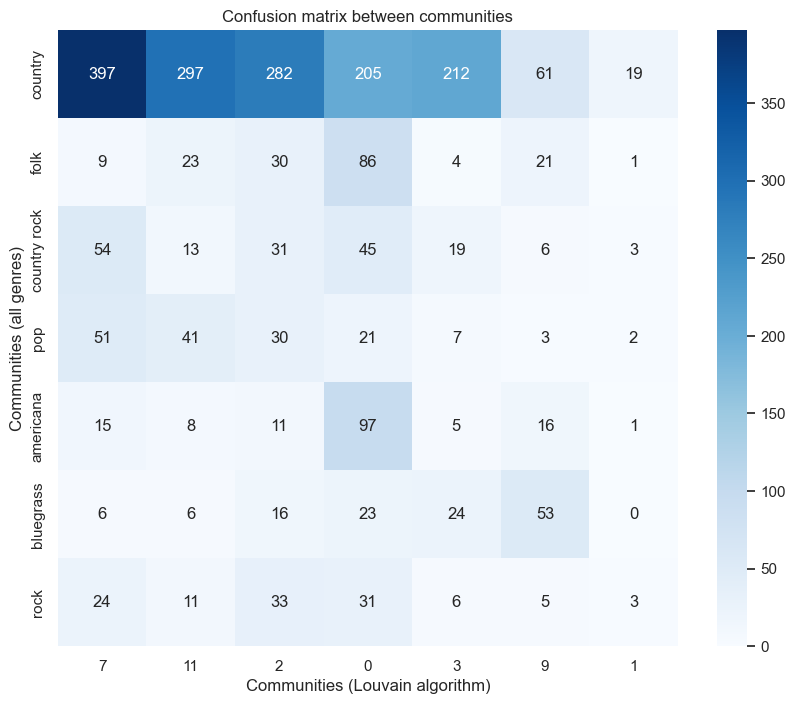

In [504]:
# Compute and plot the confusion matrix
D = create_confusion_matrix(communities_louvain_common, communities_genres_all_common)
plot_confusion_matrix(D, communities_louvain_common, communities_genres_all_common)

To-do:

- Confusion matrix of comparison between genre (with `all` selection method) vs. communities, and discuss. 

### **Exercise 1.4: Plotting the communities**

To-do:

- Plot and compare communities found based on genre vs. communities found based on Louvain algorithm. 

In [505]:
def FA2_positions(artist_undirected_graph, pos, iterations=200):
    """
    Compute the ForceAtlas2 layout for the graph

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        pos: initial positions of the nodes (dict)
        iterations: number of iterations for the layout (int)

    Returns
        positions: positions of the nodes after the layout (dict)
    """
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,  
        edgeWeightInfluence=1.0,
        jitterTolerance=0.5,  
        barnesHutOptimize=True,
        barnesHutTheta=1.8,  # Lower to increase structure
        scalingRatio=1.0,  # Reduce to prevent large spread
        strongGravityMode=False,
        gravity=0.1,  # Lower to reduce overlap
        verbose=True
    )

    # Compute the layout
    positions = forceatlas2.forceatlas2_networkx_layout(artist_undirected_graph, pos=pos, iterations=iterations)

    return positions

def assign_colors_by_genre(graph, genre_dict):
    """
    Assign a unique color ID to each node in the graph based on its genre.

    Args
        graph: undirected graph of country musicians (nx.Graph)
        genre_dict: dictionary of artist genres (dict)

    Returns

        color_assignments: list of color IDs for each node in the graph (list)
    """
    color_assignments = []
    genre_to_color = {genre: index for index, genre in enumerate(genre_dict)}  # Map each genre to a unique color ID
    # print(genre_to_color)

    for node in graph.nodes():
        assigned = False
        for genre, artists in genre_dict.items():
            if node in artists:
                color_assignments.append(genre_to_color[genre])  # Assign the genre’s color ID
                assigned = True
                break
        if not assigned:
            # If the node is not in any genre, assign a default color ID, like -1
            color_assignments.append(-1)
    return color_assignments

def create_plot(artist_undirected_graph, positions, communities, cmap_name, title):
    """
    Create a plot of the artist graph colored by the communities

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        positions: positions of the nodes in the graph (dict)
        communities: dictionary of communities (dict)
        cmap_name: name of the colormap to use (str)
        title: title of the plot (str)
    """

    color_assignments = assign_colors_by_genre(artist_undirected_graph, communities)
    cmap = plt.cm.get_cmap(cmap_name, max(color_assignments) + 1)

    
    nx.draw_networkx_nodes(artist_undirected_graph, positions, node_size=10, node_color=color_assignments, cmap=cmap)
    nx.draw_networkx_edges(artist_undirected_graph, positions, alpha=0.1)
    plt.title(title)
    plt.axis('off')

100%|██████████| 200/200 [00:23<00:00,  8.45it/s]
C:\Users\annae\AppData\Local\Temp\ipykernel_9408\671895584.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name, max(color_assignments) + 1)


BarnesHut Approximation  took  3.36  seconds
Repulsion forces  took  19.09  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.36  seconds


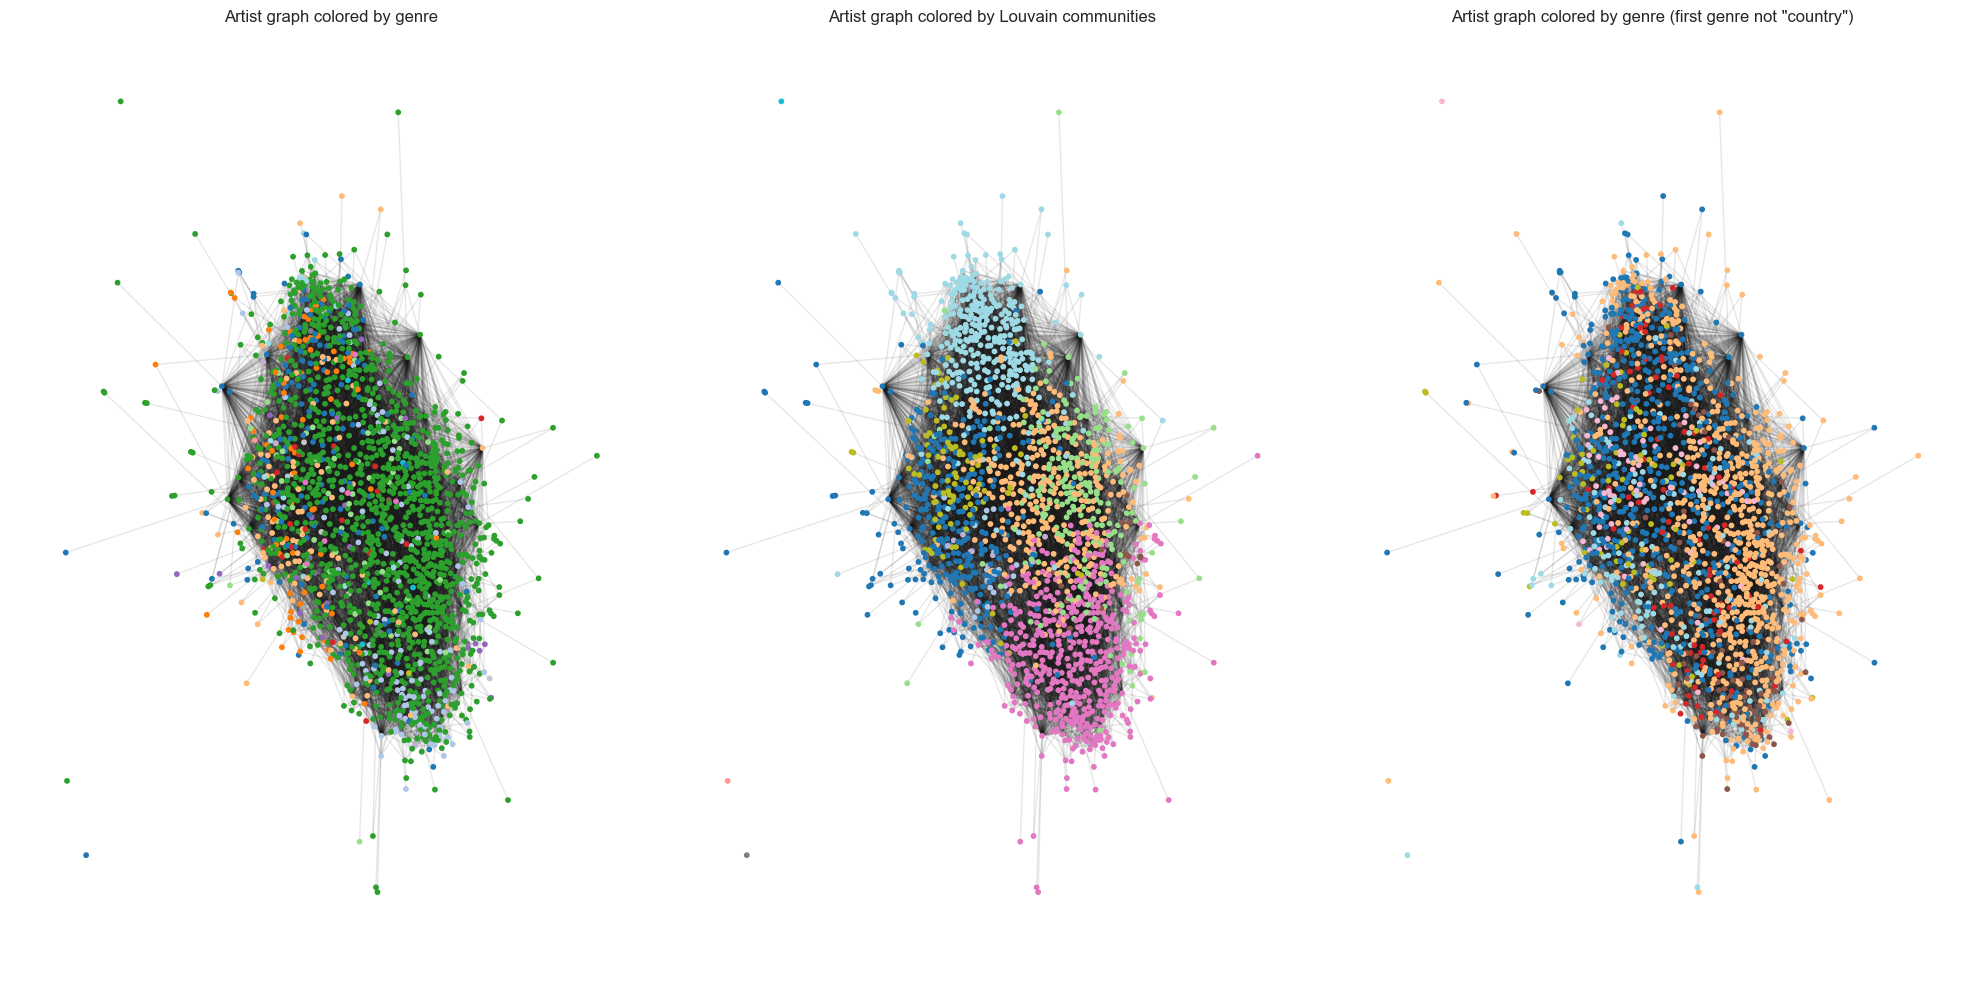

In [506]:
# Which one is the better option, try both
#positions = FA2_positions(artist_undirected_graph, pos=None, iterations=200)
initial_pos = nx.spring_layout(artist_undirected_graph)
positions = FA2_positions(artist_undirected_graph, pos=initial_pos, iterations=200)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
create_plot(artist_undirected_graph, positions, communities_genres_all, 'tab20', 'Artist graph colored by genre')
plt.subplot(1, 3, 2)
create_plot(artist_undirected_graph, positions, communities_louvain, 'tab20', 'Artist graph colored by Louvain communities')
plt.subplot(1, 3, 3)
create_plot(artist_undirected_graph, positions, communities_genres_not_country_as_first_common, 'tab20', 'Artist graph colored by genre (first genre not "country")')
plt.tight_layout()
plt.show()

# **Part 2: TF-IDF to understand genres and communities**

### **Exercise 2.1: The concept of TF-IDF**

### **Exercise 2.2: Calculating and visualizing TF-IDF for the genres and communities**

To-do:

- Word-clouds of both genre communities and Louvain communities.

- Subplot with 6 word-clouds for each (3x2). 

### **Exercise 2.3: Discussing the difference between the word-clouds between genres and communities**

To-do:

- Discuss (using confusion matrix from previous exercise) the difference between word-clouds of genre communities and Louvain communities. Look at what the artists with a Louvain community has in common, since it is not (at least not only) based on genre?

# **Part 3: Sentiment of the artists and communities**

Part 3 of the project focuses on **sentiment analysis** of the country music performers' Wikipedia content, and the communities that they have been partioned into in the previous parts of the project. The sentiment analysis is based on the [LabMT wordlist](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752), which consists of $10222$ words scored according to their happiness by users on Mechanical Turk. 

### **Exercise 3.1: Sentiment of the artist pages**

In this exercise, the sentiment of the individual artist pages is computed and investigated. Each artist Wikipedia content page is cleaned and tokenized, and then given a sentiment score based on the average happiness score of the words from the LabMT wordlist that the artist page contains.

In [507]:
def load_wordlist():
    """
    Load the LabMT wordlist.

    Returns
        wordlist: wordlist with happiness scores (pd.DataFrame)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)
    """
    wordlist = pd.read_table("wordlist.txt")
    happiness_score_dict = wordlist.set_index('word')['happiness_average'].to_dict()

    return wordlist, happiness_score_dict

# Load the LabMT wordlist
wordlist, happiness_score_dict = load_wordlist()

In [508]:
def compute_sentiment(tokens, happiness_score_dict):
    """ 
    Compute the sentiment of a tokenized text based on the LabMT wordlist.

    Args:
        tokens: tokenized text (list)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)

    Returns:
        sentiment: average sentiment score for the tokens (float)
        words_found: number of words from the wordlist found in the text (int)
    """

    happiness_scores = []   # List to store the happiness scores of the tokens
    words_found = 0         # Number of words from the workdlist found in the text

    for token in tokens:

        # Check if the token is in the wordlist
        if token in happiness_score_dict:

            # Add the happiness score to the list, and increment the number of words found
            happiness_scores.append(happiness_score_dict[token])
            words_found += 1

    # Compute the sentiment score
    if len(happiness_scores) > 0:
        sentiment = np.mean(happiness_scores)

    else:
        sentiment = 0

    return sentiment, words_found

In [509]:
def clean_text(text):
    """
    Clean a text by removing comments, templates, file links, and square bracket links.

    Args
        text: text to clean (str)

    Returns
        clean_text: cleaned text (str)
    """

    # Remove comments, templates, file links, and square bracket links
    clean_text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    clean_text = re.sub(r'\{\{.*?\}\}', '', clean_text, flags=re.DOTALL)
    clean_text = re.sub(r'\[\[File:.*?\]\]', '', clean_text, flags=re.DOTALL)
    clean_text = re.split(r"==\s?Early\s?[Ll]ife\s?==", clean_text, 1)[-1]
    clean_text = re.sub(r'\[\[|\]\]', '', clean_text)
    clean_text = re.sub(r'[^\w\s]', '', clean_text)

    return clean_text

def tokenize_text(text):
    """
    Tokenize a text into words using NLTK's word_tokenize function.

    Args:
        text: clean text to be tokenized (str)

    Returns:
        tokens: tokenized text (list)
    """

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalnum()]

    # Set tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Lemmatize tokens using NLTK's WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

Next, the sentiment score of each artist (node) was added as a node attribute in the graph.

In [ ]:
def add_sentiment_attribute(artist_undirected_graph, happiness_score_dict):
    """
    Add the sentiment attribute to the nodes in the graph, based on the text content of the Wikipedia page.

    Args 
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)

    Returns
        artist_undirected_graph: undirected graph of country musicians with sentiment attribute (nx.Graph)
    """

    for node in list(artist_undirected_graph.nodes()):

        # Convert to the format of the filenames
        node = node.replace('"', '')
        node = node.replace('/', '-')

        try: 
            with open(f"../Assignment 1/data/{node}.txt", "r", encoding="utf-8") as f:
                raw_content = f.read()
        
        except:
            continue
        
        # Clean and tokenize the text
        clean_content = clean_text(raw_content)
        tokens = tokenize_text(clean_content)

        # Skip page if it is a redirect page
        if tokens[0] == 'redirect':
            continue

        # Compute the sentiment of the text
        sentiment_score, words_found = compute_sentiment(tokens, happiness_score_dict)

        if sentiment_score > 0:
            try: 
                artist_undirected_graph.nodes[node]['sentiment_score'] = sentiment_score

            except:
                continue

        else:
            # Remove nodes with no sentiment score (because they are redirect pages)
            artist_undirected_graph.remove_node(node)

    return artist_undirected_graph

# Add the sentiment attribute to the nodes in the graph
artist_undirected_graph = add_sentiment_attribute(artist_undirected_graph, happiness_score_dict)

FileNotFoundError: [Errno 2] No such file or directory: '../Assignment 1/data/Burns_&_Poe.txt'

Multiple statistics were computed from the sentiment scores across all artists, namely the minimum, maximum, average, median, variance, as well as the 25th and 75th percentile. The distribution of the sentiment scores was plotted, with various of the aforementioned metrics marked on the plot.

In [ ]:
def compute_sentiment_statistics(artist_undirected_graph):
    """
    Compute the average, median, variance, 25th percentile, and 75th percentile of the sentiment scores.

    Args
        artist_undirected_graph: undirected graph of country musicians with sentiment attribute (nx.Graph)
    
    Returns 
        sentiment_statistics: sentiment statistics (dict)
    """
    # Get sentiment score of all nodes
    all_sentiment_scores = nx.get_node_attributes(artist_undirected_graph, 'sentiment_score')
    all_sentiment_scores = list(all_sentiment_scores.values())

    # Dictionary for storing the sentiment statistics
    sentiment_statistics = {}

    # Compute sentiment statistics
    sentiment_statistics['minimum'] = np.min(all_sentiment_scores)
    sentiment_statistics['maximum'] = np.max(all_sentiment_scores)
    sentiment_statistics['average'] = np.mean(all_sentiment_scores)
    sentiment_statistics['median'] = np.median(all_sentiment_scores)
    sentiment_statistics['variance'] = np.var(all_sentiment_scores)
    sentiment_statistics['percentile_25'] = np.percentile(all_sentiment_scores, 25)
    sentiment_statistics['percentile_75'] = np.percentile(all_sentiment_scores, 75)

    return sentiment_statistics

def plot_sentiment_statistics(artist_undirected_graph, sentiment_statistics):
    """
    Plot the sentiment statistics.

    Args
        sentiment_statistics: sentiment statistics (dict)
    """
    # Get sentiment score of all nodes
    all_sentiment_scores = nx.get_node_attributes(artist_undirected_graph, 'sentiment_score')
    all_sentiment_scores = list(all_sentiment_scores.values())

    # Define the bin edges with float intervals
    bin_edges = np.linspace(min(all_sentiment_scores), max(all_sentiment_scores), num=101) 

    # Bin the sentiment scores
    counts, bin_edges = np.histogram(all_sentiment_scores, bins = bin_edges)

    # Plotting the sentiment scores
    plt.figure(figsize=(10, 4))
    plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], label = 'Sentiment scores', color='C2', alpha = 0.5)
    plt.axvline(sentiment_statistics['average'], color='r', linestyle='-', label='Average')
    plt.axvline(sentiment_statistics['median'], color='C0', linestyle='-', label='Median')
    plt.axvline(sentiment_statistics['percentile_25'], color='C6', linestyle='--', label='Q1 (25th percentile)')
    plt.axvline(sentiment_statistics['percentile_75'], color='C6', linestyle='--', label='Q3 (75th percentile)')
    plt.xlabel('Sentiment score')
    plt.ylabel('Number of artists')
    plt.title('Distribution of sentiment scores for artist pages')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Compute sentiment statistics across all nodes
sentiment_statistics = compute_sentiment_statistics(artist_undirected_graph)

print(f'Sentiment statistics of the artist graph')
print(f'\tMinimum: {sentiment_statistics["minimum"]:.2f}')
print(f'\tMaximum: {sentiment_statistics["maximum"]:.2f}')
print(f'\tAverage: {sentiment_statistics["average"]:.2f}')
print(f'\tMedian: {sentiment_statistics["median"]:.2f}')
print(f'\tVariance: {sentiment_statistics["variance"]:.2f}')
print(f'\t25th percentile: {sentiment_statistics["percentile_25"]:.2f}')
print(f'\t75th percentile: {sentiment_statistics["percentile_75"]:.2f}')

Sentiment statistics of the artist graph
	Minimum: 4.85
	Maximum: 6.07
	Average: 5.65
	Median: 5.65
	Variance: 0.01
	25th percentile: 5.59
	75th percentile: 5.71


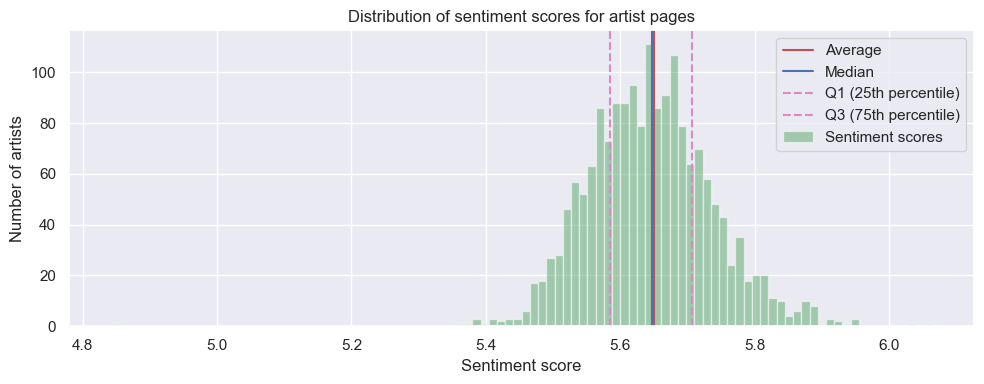

In [ ]:
plot_sentiment_statistics(artist_undirected_graph, sentiment_statistics)

From looking at the sentiment statistics across all artists, it is seen that there is not much variation in the sentiment scores, with a variance of only $0.01$. The mean and median are close together, both with a value of $5.65$ -- this suggests that the distribution of sentiment scores is nearly symmetrical, which is also supported by the above plot. The range of sentiment scores spans from a minimum of $4.85$ to a maximum of $6.07$, both of which are relatively close to the mean. The interquartile range of $[5.59, 5.71]$ is also narrow and centered closely around the mean, which further emphasized the low variability in the data.

In the LabMT wordlist, the highest ranked word has a sentiment score of $8.50$ (most positive sentiment), while the lowest ranked word has a sentiment score of $1.30$ (most negative sentiment). Considering the mean sentiment score of $5.65$ for the artist page sentiment scores, it is evident that the sentiment of the majority of the artist pages is relatively neutral, but slightly leaning towards the positive end of the happiness spectrum. This suggests that the content of the artist pages is generally balanced in terms of sentiment. This makes sense, as there are probably some standards and guidelines for writing Wikipedia pages shold be written, such that they maintain a neutral point of view on their articles, ensuring that the content is unbiased and factual. These standards likely contribute to the neutrality and low variation in sentiment scores across artist pages, as the language used is designed to be objective and consistent.

To further investigate the artist sentiment scores, we now find the top 10 happiest (highest sentiment) and saddest (lowest sentiment) artist pages. 

In [637]:
def find_top_n_pages(artist_undirected_graph, n):
    """
    Find the top pages based on the sentiment score, both the happiest and the saddest.

    Args
        artist_undirected_graph: undirected graph of country musicians with sentiment attribute (nx.Graph)
        n: number of top pages to return (int)

    Returns
        top_happiest_pages: list of n happiest pages, i.e. highest sentiment scores (list)
        top_saddest_pages: list of n saddest pages, i.e. lowest sentiment scores (list)
    """

    # Get sentiment score of all nodes
    all_sentiment_scores = nx.get_node_attributes(artist_undirected_graph, 'sentiment_score')

    # Sort the nodes based on the sentiment score
    sorted_nodes = sorted(all_sentiment_scores, key=all_sentiment_scores.get, reverse=True)

    # Get the top pages
    top_happiest_pages = sorted_nodes[:10]
    top_saddest_pages = sorted_nodes[-10:]

    return top_happiest_pages, top_saddest_pages

def compute_sentiment_for_specific_artist(tokens, happiness_score_dict):
    """ 
    Compute the sentiment of a specific artist based on the LabMT wordlist.

    Args:
        tokens: tokenized text of the artist page (list)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)

    Returns:
        words_found: words from the wordlist found in the text (int)
    """

    # Happiness score
    happiness_scores = []

    # Words from the wordlist found in the text
    words_found = [] 

    for token in tokens:

        # Check if the token is in the wordlist
        if token in happiness_score_dict:

            # Add the happiness score to the list
            happiness_scores.append(happiness_score_dict[token])

            # Add the word to the list of words found
            words_found.append(token)

    # Compute the sentiment score
    if len(happiness_scores) > 0:
        sentiment = np.mean(happiness_scores)

    else:
        sentiment = 0

    return sentiment, words_found

def words_found_for_top_pages(top_happiest_pages, top_saddest_pages, happiness_score_dict):
    """ 
    Get the words found from the wordlist in the artist page with the highest and lowest sentiment score.

    Args:
        top_happiest_pages: list of happiest pages (list)
        top_saddest_pages: list of saddest pages (list)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)
    
    Returns:
        top_pages_words_found: words found in the top pages (dict)
    """
    
    # Get the artists with the highest and lowest sentiment scores
    happiest_artist = top_happiest_pages[0]
    saddest_artist = top_saddest_pages[-2]

    # Dictionary for storing the words found in the top pages
    top_pages_words_found = {}

    for artist in [happiest_artist, saddest_artist]:
        with open(f"../Assignment 1/data/{artist}.txt", "r", encoding="utf-8") as f:
            raw_content = f.read()

            # Clean and tokenize the text
            clean_content = clean_text(raw_content)
            tokens = tokenize_text(clean_content)

            # Get the words found in the text
            sentiment, words_found = compute_sentiment_for_specific_artist(tokens, happiness_score_dict)

        # Remove duplicates
        words_found = list(set(words_found))

        # Store the words found in the dictionary
        top_pages_words_found[artist] = words_found

    return top_pages_words_found

def plot_words_found(top_pages_words_found, happiness_score_dict, num_words):
    """
    Plot the num_words words with the highest sentiment found in the happiest and saddest page.

    Args:
        top_pages_words_found: words found in the top pages (dict)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)
        num_words: number of words to plot (int)
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Create a colorbar
    norm = plt.Normalize(1, 8.5)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    for i, (artist, words) in enumerate(top_pages_words_found.items()):
        wordlist = pd.DataFrame({'Word': words, 'Happiness score': [happiness_score_dict[word] for word in words]})

        if i == 0:
            wordlist = wordlist.sort_values(by='Happiness score', ascending=False).head(num_words)
        else:
            wordlist = wordlist.sort_values(by='Happiness score', ascending=True).head(num_words)
        
        # Apply the colormap to the bars
        colors = [sm.to_rgba(score) for score in wordlist['Happiness score']]
        sns.barplot(x='Word', y='Happiness score', data=wordlist, ax=ax[i], palette=colors)
        
        if i == 0:
            ax[i].set_title(f'Selection of words found in the happiest page ({artist})')
        else:
            ax[i].set_title(f'Selection of words found in the saddest page ({artist})')
            
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].set_ylim(1, 8.5)
        ax[i].tick_params(axis='x', rotation=45)
        # ax[i].get_legend().remove()
        
    # Position the colorbar on the right-hand side
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
    cbar.set_label('Happiness score')

    plt.show()

def display_scrollable_dataframes(df1, header1, df2, header2, max_height=500):
    """ 
    Display two pandas DataFrames side by side in a scrollable format.
    """

    display(HTML(f"""
    <div style="display: flex;">
        <div style="max-height: {max_height}px; overflow-y: auto; padding: 5px; width: 50%;">
            <h3>{header1}</h3>
            {df1.to_html(index=False)}
        </div>
        <div style="max-height: {max_height}px; overflow-y: auto; padding: 5px; width: 50%;">
            <h3>{header2}</h3>
            {df2.to_html(index=False)}
        </div>
    </div>
    """))

In [624]:
# Find the top 10 happiest and saddest pages
top_happiest_pages, top_saddest_pages = find_top_n_pages(artist_undirected_graph, n=10)

# Happiest pages
happiest_df = pd.DataFrame({'Artist': top_happiest_pages, 'Sentiment': [np.round(artist_undirected_graph.nodes[page]['sentiment_score'], 2) for page in top_happiest_pages]})
happiest_df = happiest_df.sort_values(by='Sentiment', ascending=False)

# Saddest pages
saddest_df = pd.DataFrame({'Artist': top_saddest_pages, 'Sentiment': [np.round(artist_undirected_graph.nodes[page]['sentiment_score'], 2) for page in top_saddest_pages]})
saddest_df = saddest_df.sort_values(by='Sentiment', ascending=True)

# Display the tables side by side
display_scrollable_dataframes(happiest_df, 'Top 10 happiest pages', saddest_df, 'Top 10 saddest pages')

Artist,Sentiment
Dianna_Corcoran,5.95
Troy_Cassar-Daley,5.95
Adam_Harvey,5.95
Susan_McCann,5.95
Gabby_Barrett,5.94
Gina_Jeffreys,5.93
Alyssa_Micaela,5.92
Alee_(singer),5.92
Tania_Kernaghan,5.92
One_More_Girl,5.90


In the above tables, the top 10 pages with highest sentiment score (i.e. happiest) and the top 10 pages with lowest sentiment score (i.e. saddest) are listed. Once again, it is seen that there is not much variation in the sentiment scores within each of the top 10s nor between them. 

The happiest artist page of all is found to be [Dianna Corcoran](https://en.wikipedia.org/wiki/Dianna_Corcoran), while the saddest page of all is found to be [Joey Feek](https://en.wikipedia.org/wiki/Joey_Feek). To further look into why each of these pages ended at the top, we look at a selection of the words from the LabMT wordlist found in each of the artist pages. For the happiest page the highest sentiment scored words are shown, whereas for the saddest page the lowest sentiment scored words are shown.

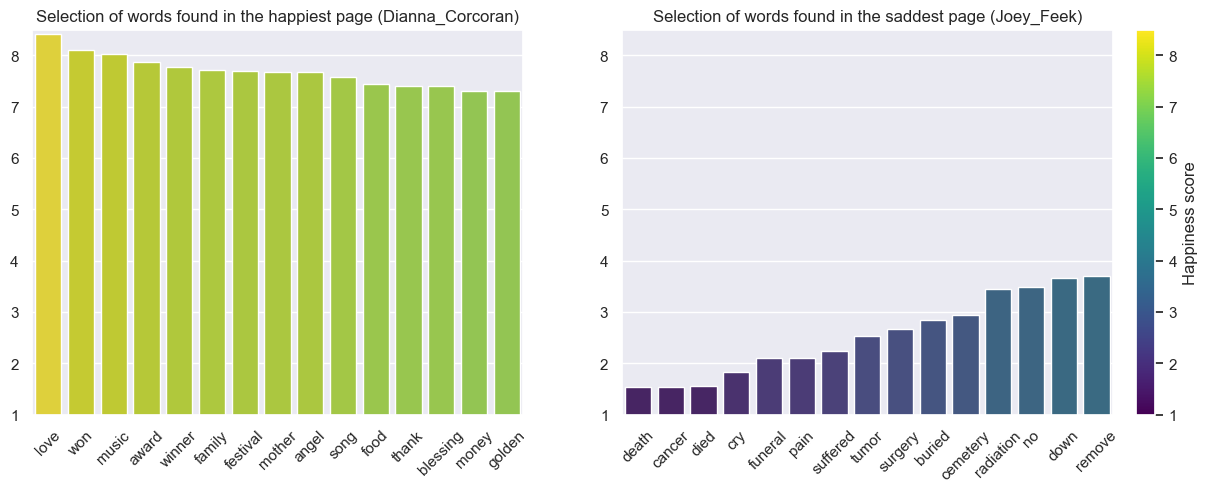

In [638]:
top_pages_words_found = words_found_for_top_pages(top_happiest_pages, top_saddest_pages, happiness_score_dict)
plot_words_found(top_pages_words_found, happiness_score_dict, num_words=15)

In the content of the artist page for [Dianna Corcoran](https://en.wikipedia.org/wiki/Dianna_Corcoran), there is a section with *Awards and nominations*, which constitutes a large part of her page. In this overview, the word `won` is written many times, for each award she won. Similarly for the word `music`, which is also repeated for many of the awards in the overview, since it is often included into the award name (e.g. *CMAA Country Music Awards*). From the above plot it can be seen that `won` and `music` are the second- and third-highest ranked words found in the artist page. Since both of them are repeated many times in the content, it will contribute to the increase of the average sentiment score of the page.

For the artist page of [Joey Feek](https://en.wikipedia.org/wiki/Joey_Feek), there is a section named *Cancer relapse*, in which it is described in detail how she was dealing with cancer disease, her treatment course, and death in the end. This section makes up about half of the content on her artist page, including many low-ranking sentiment words like `death`, `cancer`, `died`, `funeral`, and more, which is also seen in the above plot.

### **Exercise 3.2: Sentiment of the largest communities**

In this exercise, the sentiment is analyzed on community-scale, where an average sentiment score is computed from the sentiment scores of all artists beloging to the community. To simplify the analysis, only the $10$ largest communities are considered, which are ranked in top 3 according to the happiest and saddest communities.

In [656]:
def compute_sentiment_community(communities_louvain, artist_undirected_graph, n):
    """
    Compute the average sentiment score of the n largest communities in the Louvain partition.

    Args
        communities_louvain: dictionary of communities found by the Louvain algorithm (dict)
        artist_undirected_graph: undirected graph of country musicians with sentiment attribute (nx.Graph)

    Returns
        community_sentiments: dictionary of communities and their average sentiment scores (dict)
        community_ID: dictionary of communities and their cluster ID (dict)
        n_members_all: dictionary of communities and their number of members (dict)
    """

    # Get n largest communities
    communities_largest = get_n_most_common_communities(communities_louvain, n)

    # Dictionary for storing the average sentiment scores of each community
    community_sentiments = {}  # For storing the average sentiment scores of each community
    community_ID = {}          # For storing the cluster ID assigned to each community in the Louvain partition
    n_members_all = {}         # For storing the number of members in each community

    for i in list(communities_largest.keys()):

        degrees = {}
        sentiment_scores = []
        n_members = 0

        for node in communities_largest[i]:

            try: 
                # Store the sentiment score of the node
                sentiment_scores.append(artist_undirected_graph.nodes[node]['sentiment_score'])

                # Count the number of members in the community
                n_members += 1
            except:
                continue

            if isinstance(artist_undirected_graph.degree(node), int):

                # Store the degree of the node
                degrees[node] = artist_undirected_graph.degree(node)

        # Name the community by its three most connected artists
        top_3_nodes = sorted(degrees, key=degrees.get, reverse=True)[:3]
        community_name = ", ".join(top_3_nodes)

        # Compute the average sentiment score of the community
        if len(sentiment_scores) > 0:
            community_sentiments[community_name] = np.round(np.mean(sentiment_scores),2)

        # Store the number of members in the community
        n_members_all[community_name] = n_members

        # Store the cluster ID assigned to the community
        community_ID[community_name] = i

    return community_sentiments, community_ID, n_members_all

def find_top_n_communities(community_sentiments, n):
    """
    Find the top communities based on the sentiment score, both the happiest and the saddest.

    Args
        community_sentiments: dictionary of communities and their average sentiment scores (dict)
        n: number of top communities to return (int)

    Returns
        top_happiest_communities: list of n happiest communities, i.e. highest sentiment scores (list)
        top_saddest_communities: list of n saddest communities, i.e. lowest sentiment scores (list)
    """

    # Sort the communities based on the sentiment score
    sorted_communities = sorted(community_sentiments, key=community_sentiments.get, reverse=True)

    # Get the top communities
    top_happiest_communities = sorted_communities[:n]
    top_saddest_communities = sorted_communities[-n:]

    return top_happiest_communities, top_saddest_communities

In [ ]:
def calc_IDF(file_dir):
    """
    Calculate the inverse document frequency (IDF) for each term in the corpus.
    
    Args:
    file_dir: str, path to the directory containing the term frequency files
    
    Returns:
    IDF: dict, dictionary containing the IDF values for each term
    """
    N = len(os.listdir(file_dir))
    IDF = {}
    for file in os.listdir(file_dir):
        with open(os.path.join(file_dir, file), "r") as f:
            lines = f.readlines()
        for line in lines:
            term = line.split(",")[0]
            if term in IDF:
                IDF[term] += 1
            else:
                IDF[term] = 1
    for term, count in IDF.items():
        IDF[term] = np.round(np.log10(N/count+1), 3)
    return IDF

def calc_TF_IDF(file_path, IDF):
    """
    Calculate the TF-IDF values for each term in the corpus.
    
    Args:
    file_path, str, path to a file containing term frequency values
    IDF: dict, dictionary containing the IDF values for each term
    
    Returns:
    TF_IDF: dict, dictionary containing the TF-IDF values for each term
    """

    TF_IDF = {}
    with open(file_path, "r") as f:
        lines = f.readlines()
    for line in lines:
        term, TF = line.split(",")
        TF = float(TF)
        TF_IDF[term] = TF * IDF[term]
    return TF_IDF

In [ ]:
def plot_wordclouds_selected(file_dir, community_IDs, community_names, IDF, indicator):
    """
    Plot word clouds for selected communities in the graph.
    
    Args:
        file_dir: str, path to the directory containing the term frequency files
        community_IDs: list of community IDs to plot word clouds for
        community_names: list of community names corresponding to the community IDs
        IDF: dict, dictionary containing the IDF values for each term
        indicator: string to specify either 'happiest' or 'saddest'
    """
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))

    for i, ID in enumerate(community_IDs):
        TF_IDF = calc_TF_IDF(os.path.join(file_dir, f'{ID}.txt'), IDF)

        sorted_TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=True))
        # Filter out the wiki keywords and stopwords
        wiki_keywords = ['ref', 'scoperow', 'rowspan2', 'aligncenter', 'styletextaligncenter', 'classwikitable', 'plainrowheaders', 'rowspan3', 'scopecol',
                         'categorycountry', 'alignleft', 'alignright', 'stylefontsizesmaller', 'width45', 'rowspan2', 'styletextalign', 'aligncenternbsp', 
                         'wa', 'namegisslen5', 'gil', 'widthauto', 'scma', '306', 'namecalledbycountry']
        filtered_TF_IDF = {k: v for k, v in sorted_TF_IDF.items() if k not in wiki_keywords}
        stop_words = set(stopwords.words('english'))
        filtered_TF_IDF = {k: v for k, v in filtered_TF_IDF.items() if k not in stop_words}
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(filtered_TF_IDF)
        
        ax[i].imshow(wordcloud)
        ax[i].set_title(f'{community_names[i]} (ID: {ID})')
        ax[i].axis('off')

    plt.suptitle(f'Word clouds for Top 3 {indicator} communities', y=0.7, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [662]:
# Get 10 largest communities
community_sentiments, community_ID, n_members_all = compute_sentiment_community(communities_louvain, artist_undirected_graph, n=10)

# Find the top 3 happiest and saddest communities
top_happiest_communities, top_saddest_communities = find_top_n_communities(community_sentiments, n=3)

# Happiest communities
happiest_communities_df = pd.DataFrame({'Community': top_happiest_communities, 
                                        'ID': [community_ID[community] for community in top_happiest_communities],
                                        'Members': [n_members_all[community] for community in top_happiest_communities], 
                                        'Sentiment': [community_sentiments[community] for community in top_happiest_communities]})

happiest_communities_df = happiest_communities_df.sort_values(by='Sentiment', ascending=False)

# Saddest communities
saddest_communities_df = pd.DataFrame({'Community': top_saddest_communities, 
                                       'ID': [community_ID[community] for community in top_saddest_communities], 
                                       'Members': [n_members_all[community] for community in top_saddest_communities],
                                       'Sentiment': [community_sentiments[community] for community in top_saddest_communities]})

saddest_communities_df = saddest_communities_df.sort_values(by='Sentiment', ascending=True)

# Display the tables side by side
display_scrollable_dataframes(happiest_communities_df, 'Top 3 happiest communities', saddest_communities_df, 'Top 3 saddest communities')

Community,ID,Members,Sentiment
"Beccy_Cole, Tommy_Emmanuel, Troy_Cassar-Daley",1,16,5.82
"Donny_Parenteau, Beverley_Mahood, Brad_Johner",6,6,5.74
"Blue_Rodeo, Jim_Cuddy, Kathleen_Edwards",5,6,5.69
Community,ID,Members,Sentiment
Baker_&_Myers,4,1,5.50
"George_Jones, Elvis_Presley, Dolly_Parton",11,178,5.59
"Willie_Nelson, Johnny_Cash, Emmylou_Harris",0,135,5.62


The tables above display the top $3$ happiest and saddest communities, each named after their three most connected artists. Additionally, the community ID assigned by the Louvain partition is listed. For each community, the tables display the total number of members and the average sentiment score at the community level.

It is seen that the sentiment scores are quite similar across both the happiest and saddest communities. This similarity is expected, since we previously saw a low variation in sentiment scores across all artists. When sentiment scores are aggregated at the community level, this low variation is further smoothed out, resulting in even more uniform sentiment scores within communities.

Most notably is that the top 3 happiest communities are smaller communities with only $16, 6$ and $6$ members, respectively. The smaller size of these communities could contribute to their higher average sentiment scores, as the average is influenced by fewer pages. In smaller communities, individual pages with high sentiment scores have a more significant impact on the overall average. Similarly can be said for the saddest community found, *Baker & Myers*, which consists of only that single member -- meaning that the sentiment score of this community is determined solely by that one page, leading to a more extreme sentiment score. 

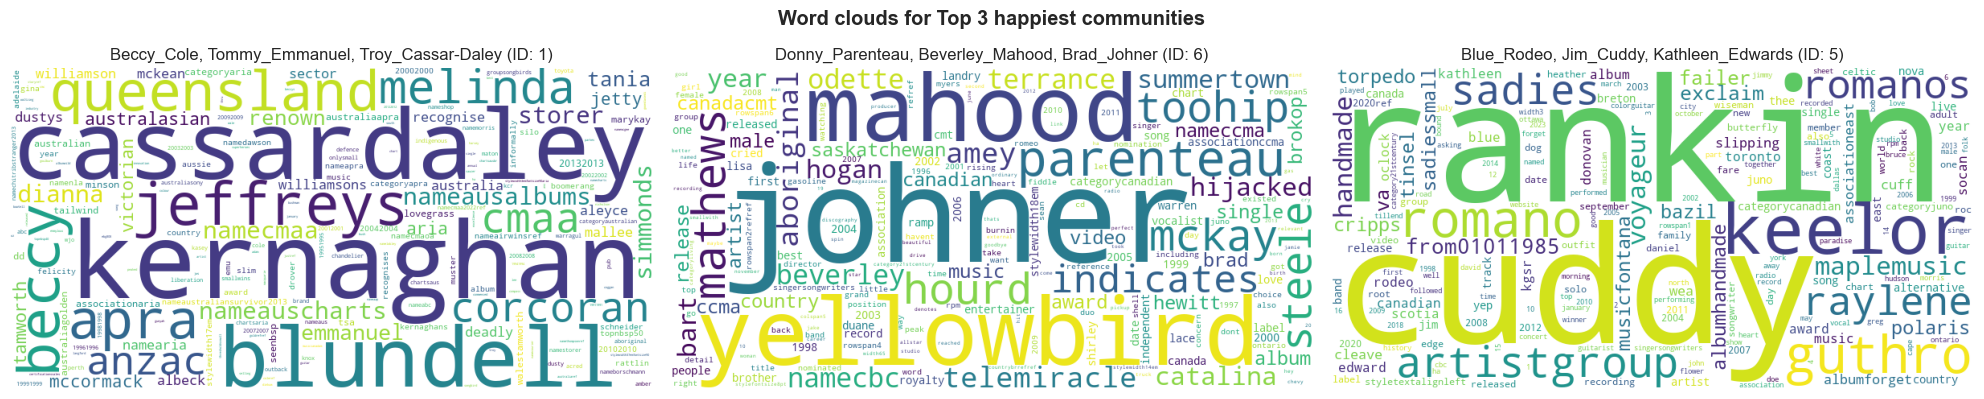

In [726]:
file_dir = "./data/TF_louvain"
IDF_louvain = calc_IDF(file_dir)

# Plot word clouds for the top 3 happiest communities
community_IDs = [1, 6, 5]
community_names = ['Beccy_Cole, Tommy_Emmanuel, Troy_Cassar-Daley', 'Donny_Parenteau, Beverley_Mahood, Brad_Johner', 'Blue_Rodeo, Jim_Cuddy, Kathleen_Edwards']
plot_wordclouds_selected(file_dir, community_IDs, community_names, IDF_louvain, indicator = 'happiest')

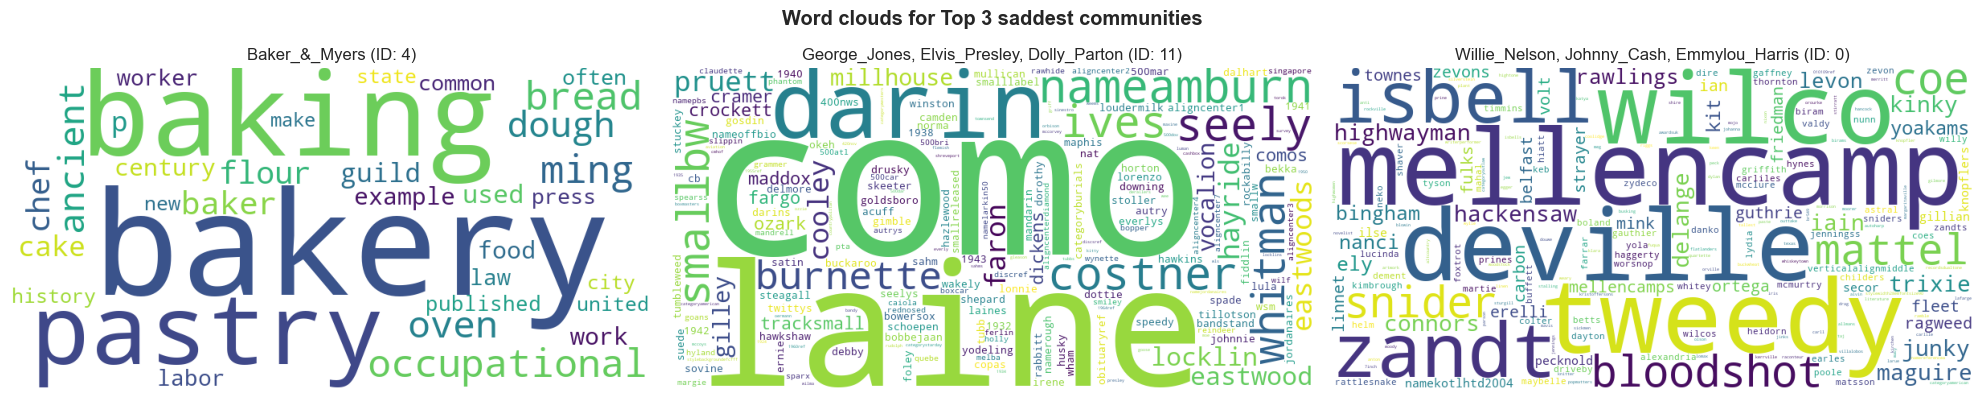

In [721]:
# Plot word clouds for the top 3 saddest communities
community_IDs = [4, 11, 0]
community_names = ['Baker_&_Myers', 'George_Jones, Elvis_Presley, Dolly_Parton', 'Willie_Nelson, Johnny_Cash, Emmylou_Harris']
plot_wordclouds_selected(file_dir, community_IDs, community_names, IDF_louvain, indicator = 'saddest')

### **Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages?**